# Geospatial Indexing

---
## Setup

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'indexing'
SERIES = 'applied-geospatial'

In [22]:
BQ_SOURCE = 'bigquery-public-data.geo_openstreetmap.planet_features'

BQ_REGION = REGION[0:2]
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE_PREFIX = EXPERIMENT

In [ ]:
import matplotlib.pyplot as plt

from google.cloud import bigquery
import bigframes.pandas as bpd

In [58]:
bq = bigquery.Client(project = PROJECT_ID)
bpd.options.bigquery.project = PROJECT_ID

In [59]:
# create/link to dataset
ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
ds.location = BQ_REGION
ds.labels = {'series': f'{SERIES}'}
ds = bq.create_dataset(dataset = ds, exists_ok = True) 

---
## Review Source

In [27]:
bq.query(query = f'''
SELECT *
FROM {BQ_SOURCE.split('.')[0]}.{BQ_SOURCE.split('.')[1]}.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS
WHERE TABLE_NAME = '{BQ_SOURCE.split('.')[2]}'
''').to_dataframe()

,table_catalog,table_schema,table_name,column_name,field_path,data_type,description,collation_name,rounding_mode
0,bigquery-public-data,geo_openstreetmap,planet_features,feature_type,feature_type,STRING,None,NULL,None
1,bigquery-public-data,geo_openstreetmap,planet_features,osm_id,osm_id,INT64,None,NULL,None
2,bigquery-public-data,geo_openstreetmap,planet_features,osm_way_id,osm_way_id,INT64,None,NULL,None
3,bigquery-public-data,geo_openstreetmap,planet_features,osm_version,osm_version,INT64,None,NULL,None
4,bigquery-public-data,geo_openstreetmap,planet_features,osm_timestamp,osm_timestamp,TIMESTAMP,None,NULL,None
5,bigquery-public-data,geo_openstreetmap,planet_features,all_tags,all_tags,"ARRAY<STRUCT<key STRING, value STRING>>",None,NULL,None
6,bigquery-public-data,geo_openstreetmap,planet_features,all_tags,all_tags.key,STRING,None,NULL,None
7,bigquery-public-data,geo_openstreetmap,planet_features,all_tags,all_tags.value,STRING,None,NULL,None
8,bigquery-public-data,geo_openstreetmap,planet_features,geometry,geometry,GEOGRAPHY,None,NULL,None


In [28]:
bq.query(query = f'SELECT * FROM `{BQ_SOURCE}` LIMIT 5').to_dataframe()

,feature_type,osm_id,osm_way_id,osm_version,osm_timestamp,all_tags,geometry
0,other_relations,8767442,<NA>,1,2018-10-02 23:36:38+00:00,[],"POLYGON((-123.2052362 39.1257422, -123.2052314..."
1,multipolygons,<NA>,710599311,1,2019-08-04 06:56:34+00:00,"[{'key': 'level', 'value': '0'}]","POLYGON((-123.2127626 39.1334776, -123.2127651..."
2,points,358763181,<NA>,1,2009-03-11 05:27:04+00:00,"[{'key': 'ele', 'value': '0'}, {'key': 'gnis:c...",POINT(-123.7272381 39.1304589)
3,points,358765882,<NA>,1,2009-03-11 05:30:36+00:00,"[{'key': 'ele', 'value': '0'}, {'key': 'gnis:c...",POINT(-123.5936233 38.7999108)
4,multipolygons,6826538,<NA>,1,2016-12-27 21:27:25+00:00,"[{'key': 'ele', 'value': '0'}, {'key': 'gnis:c...","POLYGON((-123.0778671 38.3740722, -123.0777454..."


---
## Setup For Test

### Source Table

In [49]:
query = f'''
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source` AS
    SELECT feature_type, osm_id, ST_CENTROID(geometry) as loc
    FROM `{BQ_SOURCE}`
    WHERE osm_id IS NOT NULL
'''
bq_job = bq.query(query = query)
bq_job.result()

In [50]:
(bq_job.ended - bq_job.started).total_seconds()

23.002

In [51]:
bq_job.slot_millis/1000

16978.327

### Query Table

In [52]:
query = f'''
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query` AS
    SELECT i1 * 1000 + i2 AS id, ST_GEOGPOINT(RAND() * 360, RAND() * 180 - 90) as loc
    FROM
        UNNEST(GENERATE_ARRAY(1, 1000)) i1,
        UNNEST(GENERATE_ARRAY(1, 1000)) i2
'''
bq_job = bq.query(query = query)
bq_job.result()

In [61]:
bpd.read_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query').shape

(1000000, 2)

In [63]:
bpd.read_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query').head()

,id,loc
0,784890,POINT (-21.24986 -49.21261)
1,980544,POINT (15.45033 47.76762)
2,685986,POINT (148.19335 25.52334)
3,132932,POINT (51.31743 34.01405)
4,336944,POINT (134.97116 0.30590)


---
## Test: ST_DISTANCE()

In [64]:
distances = [.1, 1, 10, 20, 40, 60, 80, 100, 120, 140]

In [ ]:
run_seconds = []
slot_seconds = []
total_neighbors = []

for distance in distances:
    query = f'''
        SELECT id, ARRAY_AGG(osm_id ORDER BY ST_DISTANCE(q.loc, s.loc) LIMIT 10) AS neighbors
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query` q
        JOIN `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source` s
        ON ST_DWITHIN(q.loc, s.loc, 1000 * {distance})
        GROUP BY id
    '''
    bq_job = bq.query(query = query, job_config = bigquery.QueryJobConfig(use_query_cache = False))
    bq_job.result()
    run_seconds.append((bq_job.ended - bq_job.started).total_seconds())
    slot_seconds.append(bq_job.slot_millis/1000)
    temp_table = '.'.join(bq_job.destination.path.split('/')[2::2])
    temp = bpd.read_gbq(temp_table)
    temp['n_neighbors'] = temp.neighbors.str.len()
    total_neighbors.append(temp['n_neighbors'].sum())

In [108]:
run_seconds

[9.209,
 11.92,
 22.33,
 39.728,
 181.53,
 626.919,
 691.885,
 2420.253,
 2757.184,
 5692.59]

In [109]:
slot_seconds

[7862.412,
 8221.25,
 17288.616,
 43164.958,
 179803.204,
 672906.964,
 660971.784,
 2529836.997,
 2742079.948,
 2714392.396]

In [110]:
total_neighbors

[16971,
 389401,
 1691734,
 2269899,
 2884107,
 3253185,
 3546474,
 3813336,
 4066409,
 4306270]

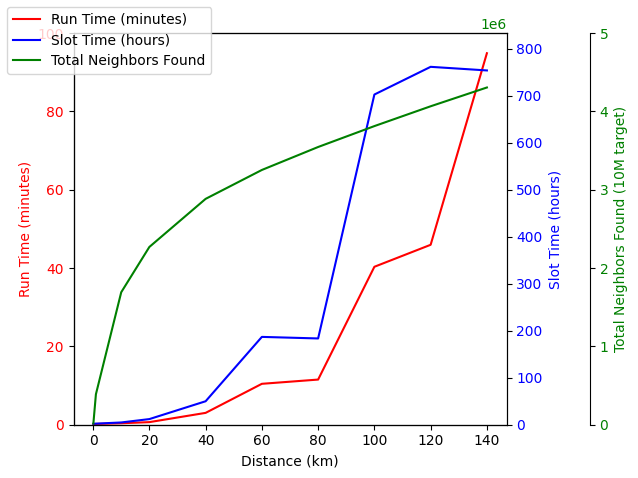

In [140]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Run Time (minutes)', color = 'red')
ax1.tick_params(axis = 'y', labelcolor = 'red')
ax1.plot(distances, [r/60 for r in run_seconds], label = 'Run Time (minutes)', color = 'red')
ax1.set_ylim(0, 6000/60)

ax2 = ax1.twinx()
ax2.set_ylabel('Slot Time (hours)', color = 'blue')
ax2.tick_params(axis = 'y', labelcolor = 'blue')
ax2.plot(distances, [(s/60)/60 for s in slot_seconds], label = 'Slot Time (hours)', color = 'blue')
ax2.set_ylim(0, (3000000/60)/60)

ax3 = ax1.twinx()
ax3.set_ylabel('Total Neighbors Found (10M target)', color = 'green')
ax3.tick_params(axis = 'y', labelcolor = 'green')
ax3.plot(distances, total_neighbors, label = 'Total Neighbors Found', color = 'green')
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylim(0, 5000000)

fig.tight_layout()
fig.legend(loc = 'upper left')
#ax2.legend(loc = 'best')
#ax3.legend(loc = 'best')
plt.show()

---
## Re-Projection

In the next section an alternative approach to finding neighboring points is used.  It uses indexing of arrays.  The numerical distances represented by the array need to be projected to a cartesian coordinate system.  The [Earth-fixed coordinate system (ECEF)](https://en.wikipedia.org/wiki/Earth-centered,_Earth-fixed_coordinate_system) is used here.  This is a three coordinate system representing the measurement from the center of the Earth.

In BigQuery, [working with geospatial data](https://cloud.google.com/bigquery/docs/geospatial-data) uses the geography data type which describes a point set on the Earth's surface on the [WGS84](https://earth-info.nga.mil/GandG/update/index.php?action=home#tab_wgs84-data) reference sphereoid.  The longitude can be extracted from a point with the [ST_X()](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions#st_x) function, and latitude with the [ST_Y()](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions#st_y) function.


The Math for converting WGS84 (Longitude, Latitude) to ECEF (X,Y,Z):
- $\phi$ = latitude converted to radians = degrees * $\pi/180$
- $\theta$ = longitude converetd to radians = degrees * $\pi/180$
- (X, Y, Z) = ($\cos(\theta) * \cos(\phi)$, $\sin(\theta) * \cos(\phi)$, $\sin(\phi)$)

The math will be deployed with a [user-defined function](https://cloud.google.com/bigquery/docs/user-defined-functions) written in javascript:

```
CREATE TEMP FUNCTION ECEF(long FLOAT64, lat FLOAT64)
RETURNS ARRAY<FLOAT64>
LANGUAGE js
AS r"""
    var pi = Math.PI;
    phi = lat * (pi / 180)
    theta = long * (pi / 180)
    x = Math.cos(theta) * Math.cos(phi)
    y = Math.sin(theta) * Math.cos(phi)
    z = Math.sin(phi)
    return [x, y, z]
"""
```

In [149]:
query = f'''
CREATE TEMP FUNCTION ECEF(long FLOAT64, lat FLOAT64)
RETURNS ARRAY<FLOAT64>
LANGUAGE js
AS r"""
    var pi = Math.PI;
    phi = lat * (pi / 180)
    theta = long * (pi / 180)
    x = Math.cos(theta) * Math.cos(phi)
    y = Math.sin(theta) * Math.cos(phi)
    z = Math.sin(phi)
    return [x, y, z]
"""
;

ALTER TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source`
ADD COLUMN IF NOT EXISTS loc_ecef ARRAY<FLOAT64>;

UPDATE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source`
SET loc_ecef = ECEF(ST_X(loc), ST_Y(loc))
WHERE TRUE;

ALTER TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query`
ADD COLUMN IF NOT EXISTS loc_ecef ARRAY<FLOAT64>;

UPDATE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query`
SET loc_ecef = ECEF(ST_X(loc), ST_Y(loc))
WHERE TRUE;
'''

In [150]:
bq_job = bq.query(query = query)
bq_job.result()

In [151]:
(bq_job.ended - bq_job.started).total_seconds()

123.986

In [152]:
bq_job.slot_millis/1000

42385.439

In [153]:
bpd.read_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source').head()

,feature_type,osm_id,loc,loc_ecef
0,lines,761343319,POINT (-105.28773 27.99151),"[-0.23282206691294283, -0.8517705930310953, 0...."
1,points,5126643955,POINT (-46.63205 -23.54093),"[0.629532000783784, -0.6664576987571126, -0.39..."
2,points,2876305585,POINT (4.75358 52.63029),"[0.6048681025761045, 0.05029873122662784, 0.79..."
3,lines,618883227,POINT (33.34389 65.97625),"[0.34009861605827346, 0.22377617618280732, 0.9..."
4,points,5091929547,POINT (15.30989 68.01918),"[0.3610131303092436, 0.09882898820731839, 0.92..."


## BigQuery Vector Search - Indexing

Currently in preview, project needs to be allowlisted with: 
https://docs.google.com/forms/d/18yndSb4dTf2H0orqA9N7NAchQEDQekwWiD5jYfEkGWk/viewform?edit_requested=true